# Noise Model Test Bank (only on QLM)

The module **model_noise** from **QQuantLib.qpu** package allows to create in an easy way noise model for simulation. The following noisy channels can be added to the noisy model in an easy way.

1. Depolarizing channel.
2. Amplitude Damping.
3. Dephasing (only if there is Amplitude Damping).
4. Measurement Channel.

In order to configure a noisy model an input dictionary with the following format should ben provided:

{

    'qpu': "noisy",# ideal or noisy
    
    't_gate_1qb': 35,# ns
    
    't_gate_2qbs': 660,# ns
    
    't_readout': 4000, # ns
    
    'depol_channel': {
        'active': True, # True or False
        'error_gate_1qb': 1.0e-4,# float
        'error_gate_2qbs': 1.0e-3 # float
    },
    
    'idle': {
        'amplitude_damping': True, # True or False
        'dephasing_channel': True, # True or False
        't1': 0.2e6, #ns
        't2': 0.1e6 #ns
    },
    
    'meas': {
        'active': True, # True or False
        'readout_error': 1.370e-2# float
    }
}

The implemented noise modle in **model_noise** module have the following assumptions:

1. The time for 1-qubit gates will be the same for all the possible 1-qubit gates: **t_gate_1qb**. Hardware model set all the 1-qubit gates (used or not) to this value.
2. The time for 2-qubit gates will be the same for all the possible 2-qubit gates: **t_gate_2qbs**. Hardware model set all the 2-qubit gates (used or not) to this value.
3. Times for 3-qubits gates (or more) **WON'T BE FIXED**. A rewritter plugin is recomended to use (in the module a toffoli rewritter is added to the final qpu).
4. Amplitude Damping channels and  Dephasing channel should be enabled under the *idle* key of the dictionary:
    * Dephasing channel will be enabled only applied if Amplitude Damping channel was enabled too. This is because $T_1$ and $T_2$ are needed for generating paramented $T_{\varphi}$ for Dephasing channel.
    * $T_{\varphi} = \frac{1}{\frac{1}{T_2} - \frac{1}{2 T_1}}$
6. Depolarizing channel should be enabled and configured under the *depol_channel* key:
    * In the *Depolarizing channel* each time an ideal gate is applied then the depolarizing channel is applied
    * The *Depolarizing channel* will be the same for the 1 and 2 qubit gates.
    * The error asociated to all the 1-qubit gates will be the same: **error_gate_1qb**
    * The error asociated to all the 2-qubit gates will be the same: : **error_gate_2qbs**
7. Only default gates in Qaptiva **DefaultHardwareModel** can be used. If *hw_model* is a **DefaultHardwareModel** object the default Qaptiva gates can be listed in the following dictionaries:
    * hw_model.gates_specification.quantum_channels: Gates and corresponding definitions. Gates can be of the following type: 
        * QuantumChannelKraus. Using *arity* attribute e can know if they are of 1, 2 or more qubits.
        * _ParametricChannel (paramétric gates of 1 qubit)
        * _CtrlParametricChannel (controlled parametric gates: 2 qubits)
    * hw_model.gates_specification.gate_times: dictionary with pair key (gate name) value (execution time of the gate)

### Toshiko

T1 = 50 # us
T2= 30 # us
F1 = 99.9 # %
F2 = 92 # %
F_ro = 90 # %

In [ ]:
import sys
sys.path.append("../../")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qat.lang.AQASM as qlm
import json
%matplotlib inline

In [ ]:
from qat.qpus import LinAlg

In [ ]:
ideal_qpu = LinAlg()

## List of gates

In [ ]:
from qat.hardware import DefaultHardwareModel

In [ ]:
hw_md = DefaultHardwareModel()

In [ ]:
# Gates and asociated quantum channels
hw_md.gates_specification.quantum_channels

In [ ]:
# The Kraus operator is the ideal gate
hw_md.gates_specification.quantum_channels["H"].kraus_operators

In [ ]:
# time of the gates
hw_md.gates_specification.gate_times

## 1. Price Option Problem

We are going to use a price estimation problem for playing with the noise models.

### 1. Price Estimation Configuration

In [ ]:
from QQuantLib.utils.benchmark_utils import create_pe_problem, combination_for_list, create_ae_pe_solution

In [ ]:
folder = "/home/gferro/FinancialApplications/benchmark/q_ae_price/jsons/"

In [ ]:
with open(folder + "domain_configuration.json") as json_file:
    domain_cfg = json.load(json_file)
with open(folder + "density_probability.json") as json_file:
    density_cfg = json.load(json_file)
with open(folder+ "european_untracked.json") as json_file:
    payoff_cfg = json.load(json_file)

In [ ]:
pe_problem = create_pe_problem(domain_cfg, payoff_cfg, density_cfg)

In [ ]:
pe_problem

In [ ]:
price_problem = pe_problem[0]

In [ ]:
price_problem

### 2. Create associated arrays

In [ ]:
from noise_test_bank_functions import create_arrays

In [ ]:
domain, norm_pay_off, norm_p_x, pay_off_normalisation, p_x_normalisation = create_arrays(price_problem)

In [ ]:
plt.plot(domain, norm_p_x, '-o')

In [ ]:
plt.plot(domain, norm_pay_off, '-o')

In [ ]:
integral = np.sum(norm_p_x * norm_pay_off)
integral

### 3. Load arrays in an Quantum circuit 

In [ ]:
from QQuantLib.DL.encoding_protocols import Encoding

In [ ]:
encode_class = Encoding(
    array_function=norm_pay_off,
    array_probability=norm_p_x,
    encoding=2
)
encode_class.run()

In [ ]:
c = encode_class.oracle
%qatdisplay c

### 4. Amplitude Estimation Algorithm

We are going to use a **AE** algorithm.

In [ ]:
# primero carga la configuración del algoritmo AE
with open(folder+ "rqae_configuration_untracked.json") as json_file:
    ae_cfg = json.load(json_file)
ae_solver_rqae = combination_for_list(ae_cfg)
ae_problem = ae_solver_rqae[0]
ae_problem.update({"qpu": ideal_qpu})

In [ ]:
ae_problem

In [ ]:
from QQuantLib.AE.real_quantum_ae import RQAE

In [ ]:
rqae_object = RQAE(
    oracle=encode_class.oracle,
    target=encode_class.target,
    index=encode_class.index,
    **ae_problem
)

### 5. First circuit

We are going to use **RQAE**. Some typical **RQAE** parameters are needed. 

In [ ]:
from noise_test_bank_functions import first_step

In [ ]:
rqae_object.epsilon, rqae_object.ratio, rqae_object.gamma

In [ ]:
shift, n_i, gamma_i, theoretical_epsilon = first_step(rqae_object.epsilon, rqae_object.ratio, rqae_object.gamma)

In [ ]:
shift

In [ ]:
# Setting the shift for the first circuit in RQAE
rqae_object.shifted_oracle = 2.0 * shift
routine = rqae_object._shifted_oracle

In [ ]:
%qatdisplay routine

### 6. Solving the problem Problema

The following code is used for solving first step of RQAE

In [ ]:
from QQuantLib.utils.data_extracting import get_results
from QQuantLib.utils.utils import measure_state_probability

def first_step(rutina, qpu, shots, target, shift, gamma, rqae_object):
    """
    This function implements the first step of the RQAE paper. The result
    is a first estimation of the desired amplitude.
                                                                          
    Parameters
    ----------
    shift : float
        shift for the first iteration
    shots : int
        number of measurements
    gamma : float
        accuracy
                                                                          
    Returns
    ----------
    amplitude_min : float
       lower bound for the amplitude to be estimated
    amplitude_max : float
       upper bound for the amplitude to be estimated
                                                                          
    """
                                                                          
    results, circuit, _, _ = get_results(
        rutina, qpu, shots=shots
    )
                                                                          
                                                                          
    probability_sum = measure_state_probability(
        results, [0] + list(target)
    )
                                                                          
    #probability_diff = results["Probability"].iloc[
    #    bitfield_to_int([1] + list(self.target))
    #]
    probability_diff = measure_state_probability(
        results, [1] + list(target)
    )
    
    return (probability_sum - probability_diff) / (4 * shift)
    

## 7. Ideal Solution

In order to get the ideal solution we need to instantiate a ideal qpu. For loading a ideal qpu we can use the typical **get_qpu** from **QQuantLib.qpu** package. In order to have a better integration between ideal QPUs and noisy QPUs a wrapper function called *select_qpu* inside of the  **QQuantLib.qpu.select_qpu** module was implemented. 

The input of the *select_qpu* function is a dictionary like the used for configuring a noise model:


In [ ]:
from QQuantLib.qpu.select_qpu import select_qpu

In [ ]:
qpus = ["c", "python", "linalg", "mps", "qlmass_linalg", "qlmass_mps"]
conf_ideal = [{
    "qpu_type": [qpus[2]],
    "t_gate_1qb" : [None],
    "t_gate_2qbs" : [None],
    "t_readout": [None],
    "depol_channel" : [{
        "active": False,
        "error_gate_1qb" : None,
        "error_gate_2qbs" : None
    }],
    "idle" : [{
        "amplitude_damping": False,
        "dephasing_channel": False,
        "t1" : None,
        "t2" : None
    }],
    "meas": [{
        "active":False,
        "readout_error": None
    }]
}]

# We use the combination_for_list for getting the proper format for the dictionary
ideal_qpu_conf = combination_for_list(conf_ideal)[0]
print(ideal_qpu_conf)

In [ ]:
ideal_qpu = select_qpu(ideal_qpu_conf)

In [ ]:
# Ideal Solution
ideal_meas = first_step(routine, ideal_qpu, 0, rqae_object.target, shift, gamma_i, rqae_object)

In [ ]:
ideal_meas

## 8. Solution with Noisy hardware

For simulating the noisy hardware we need to configure the noisy hardware model and create a noisy QPU. This can be done with the *create_qpu* from **QQuantLib.qpu.model_noise**. However we recommend to use the wrapper function *select_qpu* from **QQuantLib.qpu.select_qpu** module 

### 8.1 No Noise and Toffoli rewritter

We can use an ideal qpu but ask for a rewritting of toffolis to 1 and 2 qubits gates. This can be by configuring the noise dictionary in the following way:

In [ ]:
ideal_toffoli_rewritter = [{
    "qpu_type": ["ideal"],
    "t_gate_1qb" : [None],
    "t_gate_2qbs" : [None],
    "t_readout": [None],
    "depol_channel" : [{
        "active": False,
        "error_gate_1qb" : None,
        "error_gate_2qbs" : None
    }],
    "idle" : [{
        "amplitude_damping": False,
        "dephasing_channel": False,
        "t1" : None,
        "t2" : None
    }],
    "meas": [{
        "active":False,
        "readout_error": None
    }]
}]
conf_ideal_no_toffoli = combination_for_list(ideal_toffoli_rewritter)[0]
conf_ideal_no_toffoli

In [ ]:
ideal_qpu_toffoli_rew = select_qpu(conf_ideal_no_toffoli)

In [ ]:
# Original Circuit has Toffolis
%qatdisplay routine --depth

In [ ]:
# Compile circuit for rewrite toffolis
from qat.core import Job, Batch
batch = Batch(jobs=[routine.to_circ().to_job()])
new_circ = ideal_qpu_toffoli_rew.compile(batch).jobs[0].circuit

In [ ]:
# New circuit has not Toffolis
%qatdisplay new_circ --svg

In [ ]:
# deal soltuion. No Toffoli circuit
ideal_no_toffoli_meas = first_step(routine, ideal_qpu_toffoli_rew, 0, rqae_object.target, shift, gamma_i, rqae_object)

In [ ]:
#Shoud be simmilar
ideal_no_toffoli_meas, ideal_meas

In [ ]:
np.abs(ideal_no_toffoli_meas-ideal_meas)

### 8.2 Depolarizing channel

### Toshiko

T1 = 50 # us
T2= 30 # us
F1 = 99.9 # %
F2 = 92 # %
F_ro = 90 # %

In [ ]:
# Configuring test for Deploarizing channel
conf_noise = [{
    "qpu_type": ["noisy"],
    "t_gate_1qb" : [35],
    "t_gate_2qbs" : [660],
    "t_readout": [0],
    "depol_channel" : [
        {
            "active": True,
            "error_gate_1qb" : 1.0e-9,
            "error_gate_2qbs" : 1.0e-8
        },
        {
            "active": True,
            "error_gate_1qb" : 1.0e-8,
            "error_gate_2qbs" : 1.0e-7
        },       
        {
            "active": True,
            "error_gate_1qb" : 1.0e-7,
            "error_gate_2qbs" : 1.0e-6
        },               
        {
            "active": True,
            "error_gate_1qb" : 1.0e-6,
            "error_gate_2qbs" : 1.0e-5
        },   
        {
            "active": True,
            "error_gate_1qb" : 1.0e-5,
            "error_gate_2qbs" : 1.0e-4
        },  
        {
            "active": True,
            "error_gate_1qb" : 2.27e-4, # brisbane
            "error_gate_2qbs" : 7.741e-3 # brisbane
        },        
        {
            "active": True,
            "error_gate_1qb" : 0.001, # Toshiko
            "error_gate_2qbs" : 0.08 # Toshiko
        },            
    ],
    "idle" : [{
        "amplitude_damping": False,
        "dephasing_channel": False,
        "t1" : None,
        "t2" : None
    }],
    "meas": [{
        "active":False,
        "readout_error": None
    }]
}]
# Now we have a list with different dictionaries
noisy_conf_list = combination_for_list(conf_noise)

In [ ]:
# Now we are going to solve the circuit with all the different depolarising channel configurations
a_depol = []

error1 = []
for hw_m in noisy_conf_list:
    my_noisy_qpu = select_qpu(hw_m)
    print(hw_m)
    error1.append(hw_m["depol_channel"]["error_gate_1qb"])
    step = first_step(routine, my_noisy_qpu, 0, rqae_object.target, shift, gamma_i, rqae_object)
    a_depol.append(step)

In [ ]:
plt.plot(error1, np.abs(a_depol - ideal_no_toffoli_meas), '-o')
#plt.axhline(medida_no_toffoli, c='r')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Error 1 qubit gate")
plt.ylabel(r"$\hat{a}-a_{ideal}$")
plt.title("k=0. Only depolarizing channel. No iddle qubit")

In [ ]:
plt.plot(error1, a_depol, '-o')
plt.axhline(ideal_no_toffoli_meas, c='r')
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("Error 1 qubit gate")
plt.ylabel(r"$\hat{a}$")
plt.title("k=0. Only depolarizing channel. No iddle qubit")

### 8.3 Amplitude Damping Channel (No Dephasing)

### Toshiko

T1 = 50 # us
T2= 30 # us
F1 = 99.9 # %
F2 = 92 # %
F_ro = 90 # %

In [ ]:
conf_noise = [{
    "qpu_type": ["noisy"],
    "t_gate_1qb" : [35],
    "t_gate_2qbs" : [660],
    "t_readout": [0],
    "depol_channel" : [
        {
            "active": False,
            "error_gate_1qb" : None,
            "error_gate_2qbs" : None
        }          
    ],
    "idle" : [
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 1000e6,
            "t2" : None
        },
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 100e6,
            "t2" : None
        },        
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 10e6,
            "t2" : None
        },     
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 1e6,
            "t2" : None
        },  
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 0.231e6, # brisbane
            "t2" : None 
        },       
        {
            "amplitude_damping": True,
            "dephasing_channel": False,
            "t1" : 50e3, # Toshiko: 50 us
            "t2" : None 
        }        
    ],
    "meas": [{
        "active":False,
        "readout_error": None
    }]
}]
noisy_conf_list = combination_for_list(conf_noise)

In [ ]:
a_ad = []

error1 = []
for hw_m in noisy_conf_list:
    my_noisy_qpu = select_qpu(hw_m)
    print(hw_m)
    error1.append(hw_m["idle"]["t1"])
    step = first_step(routine, my_noisy_qpu, 0, rqae_object.target, shift, gamma_i, rqae_object)
    a_ad.append(step)

In [ ]:
%matplotlib inline
plt.plot(error1, ideal_no_toffoli_meas - a_ad, '-o')
#plt.axhline(medida_no_toffoli, c='r')
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("T1 (ns)")
plt.ylabel(r"$\hat{a}-a_{ideal}$")
plt.title("k=0. Only Amplitude Damping. Ideal Gates")

In [ ]:
plt.plot(error1, a_ad, '-o')
plt.axhline(ideal_no_toffoli_meas, c='r')
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("T1 (ns)")
plt.ylabel(r"$\hat{a}$")
plt.title("k=0. Only depolarizing channel. No iddle qubit")

### 8.4 Amplitude Damping and Dephasing Channels

### Toshiko

T1 = 50 # us
T2= 30 # us
F1 = 99.9 # %
F2 = 92 # %
F_ro = 90 # %

In [ ]:
conf_noise = [{
    "qpu_type": ["noisy"],# Palabara para generar qpus ruidosas
    "t_gate_1qb" : [35],
    "t_gate_2qbs" : [660],
    "t_readout": [0],
    "depol_channel" : [
        {
            "active": False,
            "error_gate_1qb" : None,
            "error_gate_2qbs" : None
        }          
    ],
    "idle" : [
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 1000e6,
            "t2" : 500e6
        },
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 100e6,
            "t2" : 50e6
        },        
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 10e6,
            "t2" : 5e6
        },     
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 1e6,
            "t2" : 0.5e6
        },  
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 0.231e6, # brisbane
            "t2" : 0.132e6 # brisbane
        }, 
        {
            "amplitude_damping": True,
            "dephasing_channel": True,
            "t1" : 50e3,  # Toshiko: 50 us
            "t2" : 30e3 # Toshiko: 30 us
        },              
    ],
    "meas": [{
        "active":False,
        "readout_error": None
    }]
}]
noisy_conf_list = combination_for_list(conf_noise)

In [ ]:
a_ad_d = []

error1 = []
for hw_m in noisy_conf_list:
    my_noisy_qpu = select_qpu(hw_m)
    print(hw_m)
    error1.append(hw_m["idle"]["t1"])
    step = first_step(routine, my_noisy_qpu, 0, rqae_object.target, shift, gamma_i, rqae_object)
    a_ad_d.append(step)

In [ ]:
plt.plot(error1, np.abs(a_ad_d - ideal_no_toffoli_meas), '-o')
#plt.axhline(medida_no_toffoli, c='r')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("T1 (ns)")
plt.ylabel(r"$\hat{a}-a_{ideal}$")
plt.title("k=0. Amplitude Damping and Dephasing. Ideal Gates")

In [ ]:
plt.plot(error1, a_ad_d, '-o')
plt.axhline(ideal_no_toffoli_meas, c='r')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("T1 (ns)")
plt.ylabel(r"$\hat{a}$")
plt.title("k=0. Amplitude Damping and Dephasing. Ideal Gates")

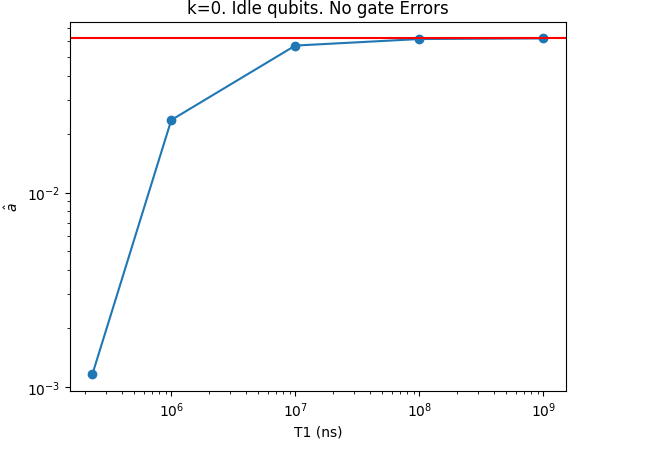

### 8.5 Redout error

### Toshiko

T1 = 50 # us
T2= 30 # us
F1 = 99.9 # %
F2 = 92 # %
F_ro = 90 # %

In [ ]:
conf_noise = [{
    "qpu_type": ["noisy"],
    "t_gate_1qb" : [35],
    "t_gate_2qbs" : [660],
    "t_readout": [0],
    "depol_channel" : [
        {
            "active": False,
            "error_gate_1qb" : None,
            "error_gate_2qbs" : None
        }          
    ],
    "idle" : [
        {
            "amplitude_damping": False,
            "dephasing_channel": False,
            "t1" : None,
            "t2" : None
        }          
    ],
    "meas": [
        {
            "active":True,
            "readout_error": 1e-6
        },
        {
            "active":True,
            "readout_error": 1e-5
        },
        {
            "active":True,
            "readout_error": 1e-4
        },        
        {
            "active":True,
            "readout_error": 1e-3
        }, 
        {
            "active":True,
            "readout_error": 1.300e-2 # brisbane
        },
        {
            "active":True,
            "readout_error": 0.1 #Toshiko
        }        
    ]
}]
noisy_conf_list = combination_for_list(conf_noise)

In [ ]:
a_read = []

error1 = []
for hw_m in noisy_conf_list:
    my_noisy_qpu = select_qpu(hw_m)
    print(hw_m)
    error1.append(hw_m["meas"]["readout_error"])
    step = first_step(routine, my_noisy_qpu, 0, rqae_object.target, shift, gamma_i, rqae_object)
    a_read.append(step)

In [ ]:
plt.plot(error1, np.abs(a_read - ideal_no_toffoli_meas), '-o')
#plt.axhline(medida_no_toffoli, c='r')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Readout Error")
plt.ylabel(r"$\hat{a}-a_{ideal}$")
plt.title("k=0. Only Readout Error.")

In [ ]:
plt.plot(error1, a_read, '-o')
plt.axhline(ideal_no_toffoli_meas, c='r')
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("Readout Error")
plt.ylabel(r"$\hat{a}$")
plt.title("k=0. Only Readout Error.")